In [1]:
import os
from datetime import datetime,timedelta 

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tqdm import tqdm_notebook
from evaluation import forecast_accuracy
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (20, 7)

In [2]:
df = pd.read_pickle('../dataset/preprocessed/48_imputed.pkl')

## With Only Reservation Data

In [3]:
def preprocess(dx, cutoff = [0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]):
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    dx = dx.replace([np.inf, -np.inf], np.nan)

    # @impute: if available room = 0 set it to maximum
    dx.loc[dx['Rooms']==0,'Rooms'] = dx['Rooms'].max()
    # @normalize: over booking to maximum number of rooms 
    dx.loc[dx['ROH']>dx['Rooms'],'ROH'] = dx['Rooms'].max()
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    dx['DBA'] = 89 - dx['DBA']
    dx = dx[dx.DBA.isin(cutoff)]
    dx['OCC'] = dx['ROH']/dx['Rooms']

    # DBA as attributes 
    dx = dx.pivot(index='DOA', columns='DBA', values='OCC')
    # Removing sub index from Dataframe
    dx = dx.rename_axis(None, axis = 0)
    cols = {col:'ROH'+str(int(col+1)).zfill(2) for col in dx.columns }

    # renaming columns
    dx = dx.rename(columns=cols)
    dx = dx.rename(columns={'ROH01':'ROH'})

    # reversing the sequance of attributes
    return dx.sort_index(axis=1 ,ascending=False)

def train_test_split(dx):
    index = int(len(dx)*0.8)
    train = dx[:index]
    test  = dx[index:]
    return train,test

def plot_train_test(train, test):
    plt.plot(train.index, train['ROH'], label='Train')
    plt.plot(test.index, test['ROH'], label='Test')
    plt.xlabel('DOA')
    plt.ylabel('ROH')
    plt.legend(loc='best')
    plt.show()

def plot_result(dx):
    plt.plot(dx.index, dx['ROH'], label='test')
    plt.plot(dx.index, dx['PRED'], linestyle='--', color='#ff7823', label="Predicted")
    plt.xlabel('Day of Arrival (DOA)')
    plt.ylabel('Reservations on Hand (ROH)')
    plt.title("LSTM (RMSE={})".format(0.0027))
    plt.legend(loc='best')
    plt.show()

# @ref: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def createModel(X,y):
    n_features = X.shape[2]
    n_steps = X.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=200, verbose=0)
    return model

In [4]:
data = preprocess(df)
train,test = train_test_split(data)
train.head(10)

DBA,ROH90,ROH60,ROH30,ROH21,ROH14,ROH07,ROH06,ROH05,ROH04,ROH03,ROH02,ROH
2018-01-01,0.019608,0.160000,0.440000,0.590909,0.744186,0.744186,0.744186,0.767442,0.767442,0.790698,0.813953,0.860465
2018-01-02,0.217391,0.340909,0.386364,0.522727,0.581395,0.744186,0.767442,0.767442,0.767442,0.767442,0.813953,0.906977
2018-01-03,0.260870,0.340909,0.386364,0.545455,0.674419,0.720930,0.744186,0.744186,0.720930,0.860465,0.906977,0.906977
2018-01-04,0.152174,0.227273,0.318182,0.431818,0.418605,0.488372,0.465116,0.488372,0.604651,0.674419,0.697674,0.860465
2018-01-05,0.108696,0.181818,0.295455,0.318182,0.325581,0.372093,0.395349,0.395349,0.465116,0.488372,0.511628,0.813953
2018-01-06,0.043478,0.431818,0.428571,0.448980,0.437500,0.511628,0.534884,0.581395,0.604651,0.627907,0.651163,0.674419
2018-01-07,0.021739,0.022727,0.045455,0.090909,0.116279,0.139535,0.162791,0.236842,0.263158,0.236842,0.210526,0.277778
2018-01-08,0.043478,0.068182,0.159091,0.232558,0.372093,0.365854,0.390244,0.414634,0.439024,0.414634,0.538462,0.812500
2018-01-09,0.043478,0.068182,0.181818,0.255814,0.441860,0.465116,0.488372,0.488372,0.465116,0.585366,0.692308,0.941176
2018-01-10,0.021739,0.045455,0.136364,0.325581,0.395349,0.511628,0.511628,0.511628,0.609756,0.625000,0.700000,0.974359


In [5]:
# choose a number of time steps
n_steps = 1
train_X, train_y = split_sequences(train.values, n_steps)
test_X, test_y = split_sequences(test.values, n_steps)

In [6]:
model = createModel(train_X, train_y)
test['PRED'] = model.predict(test_X)

<ipython-input-6-3f217b399bd7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PRED'] = model.predict(test_X)


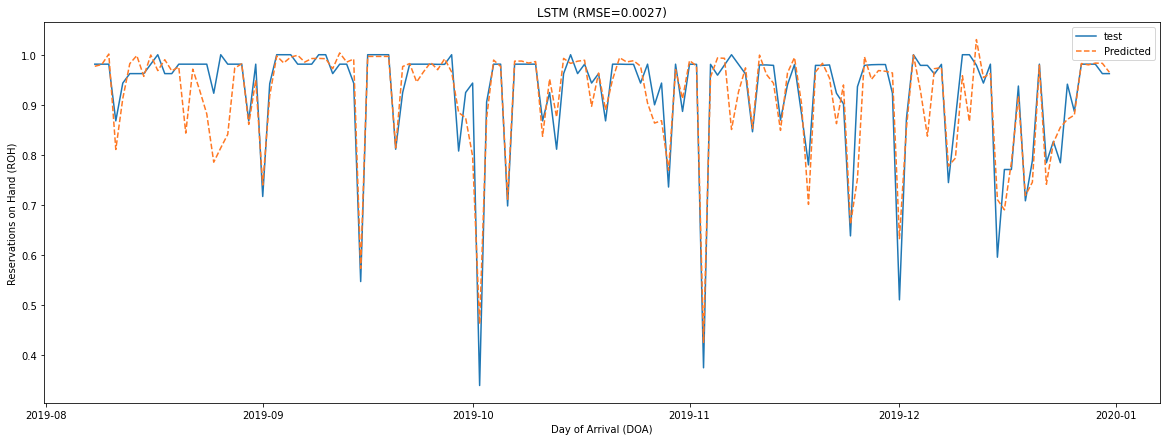

In [7]:
plot_result(test)

In [11]:

df = pd.read_csv('../dataset/results.csv')
df['LSTM'] = test.rename(columns={"PRED":"LSTM"})[['LSTM']].values
df.to_csv('../dataset/results.csv')


In [13]:
forecast_accuracy(test['PRED'],test_y)

0.0554	&	0.0097	&	0.0393	&	4.6534	&	0.0569	&	0.0032	&	0.7615


## With attributes

In [6]:
def preprocess(dx, cutoff = [0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]):
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    dx = dx.replace([np.inf, -np.inf], np.nan)
    dx = dx[~dx['LAR'].isna()]
    # @impute: if available room = 0 set it to maximum
    dx.loc[dx['Rooms']==0,'Rooms'] = dx['Rooms'].max()
    # @normalize: over booking to maximum number of rooms 
    dx.loc[dx['ROH']>dx['Rooms'],'ROH'] = dx['Rooms'].max()
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    dx['DBA'] = 89 - dx['DBA']
    dx = dx[dx.DBA.isin(cutoff)]
    dx['OCC'] = dx['ROH']/dx['Rooms']

    # DBA as attributes 
    occ = dx.pivot(index='DOA', columns='DBA', values='OCC')
    # Removing sub index from Dataframe
    occ = occ.rename_axis(None, axis = 0)
    cols = {col:'ROH'+str(int(col+1)).zfill(2) for col in occ.columns }
    # renaming columns
    occ = occ.rename(columns=cols)
    occ = occ.rename(columns={'ROH01':'ROH'}).sort_index(axis=1 ,ascending=False)

    # DBA as attributes 
    lar = dx.pivot(index='DOA', columns='DBA', values='LAR')
    # Removing sub index from Dataframe
    lar = lar.rename_axis(None, axis = 0)
    cols = {col:'LAR'+str(int(col+1)).zfill(2) for col in lar.columns }
    # renaming columns
    lar = lar.rename(columns=cols)
    lar = lar.rename(columns={'LAR01':'LAR'})

    lar['DOW'] = lar.index.dayofweek
    lar['Mon'] = lar.index.month
    lar['Day'] = lar.index.day
    # standardizing prices
    scaler = StandardScaler()
    lar[lar.columns] = scaler.fit_transform(lar[lar.columns])

    dx = pd.concat([lar, occ],axis=1)
    # reversing the sequance of attributes
    return dx

# Combined

In [7]:
cuttoffs = [1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
clean_hotels = [  48,   80,   86,  148,  151,  199,  269,  284,  317,  322,  577,1041, 1100, 1479, 1968, 4290]
for i in range(0,len(cuttoffs)):
    print('- DBA ',i)
    for hotelId in clean_hotels:
        df = pd.read_pickle('../dataset/preprocessed/'+str(hotelId)+'_imputed.pkl')
        # [0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
        df = preprocess(df, [0]+cuttoffs[i:])
        train, test = train_test_split(df)
        # choose a number of time steps
        n_steps = 1
        train_X, train_y = split_sequences(train.values, n_steps)
        test_X, test_y = split_sequences(test.values, n_steps)
        ## creating model
        model = createModel(train_X, train_y)
        test['PRED'] = model.predict(test_X)
        # plot_result(test)
        forecast_accuracy(test['PRED'],test_y)

- DBA  0
0.0561	&	0.0118	&	0.0411	&	4.7893	&	0.0578	&	0.0033	&	0.7543
0.0481	&	-0.0196	&	0.0395	&	4.8105	&	0.0496	&	0.0025	&	0.826
0.057	&	-0.0089	&	0.0393	&	5.8755	&	0.057	&	0.0033	&	0.9316
0.045	&	-0.0253	&	0.0345	&	4.8034	&	0.0474	&	0.0022	&	0.94
0.0411	&	-0.0143	&	0.0349	&	3.9376	&	0.043	&	0.0018	&	0.8517
0.2744	&	-inf	&	0.1623	&	inf	&	0.2758	&	0.076	&	-0.0769
0.0562	&	0.0167	&	0.0441	&	5.0558	&	0.0594	&	0.0035	&	0.7271
0.0568	&	0.0049	&	0.0415	&	4.5677	&	0.0572	&	0.0033	&	0.6672
0.0563	&	-0.0057	&	0.0415	&	4.824	&	0.0563	&	0.0032	&	0.6479
0.0379	&	-0.0146	&	0.0316	&	3.6208	&	0.0396	&	0.0016	&	0.8177
0.0404	&	-0.0182	&	0.0321	&	4.3498	&	0.0422	&	0.0018	&	0.9609
0.0219	&	0.0093	&	0.0183	&	2.1646	&	0.0234	&	0.0005	&	0.8434
0.0374	&	-0.0103	&	0.0288	&	3.3223	&	0.038	&	0.0014	&	0.783
0.0402	&	-0.0223	&	0.0317	&	3.5691	&	0.0442	&	0.002	&	0.8819
0.055	&	0.0006	&	0.0426	&	5.2381	&	0.0551	&	0.003	&	0.8769
0.0572	&	0.0267	&	0.0456	&	5.1453	&	0.0626	&	0.0039	&	0.6985
- DBA  1
0.0712	&	0.0264

KeyboardInterrupt: 